In [2]:
from google.colab import drive
drive.mount('/content/drive')
! pip install -U accelerate
! pip install -U transformers
! pip install datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, PreTrainedTokenizerFast, GPT2Config
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import itertools
import random
import csv
import os

torch.cuda.empty_cache()

# 토크나이저와 모델 구성 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

config = GPT2Config.from_pretrained("skt/kogpt2-base-v2")
config.attention_probs_dropout_prob = 0.1  # 어텐션 드롭아웃
config.resid_pdrop = 0.1  # 잔차 드롭아웃
config.embd_pdrop = 0.1  # 임베딩 드롭아웃

model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2", config=config)

# 데이터 읽기 함수
def read_tales(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        tales = f.read().strip().split('///')

    return [tale.strip() for tale in tales if tale.strip()]

# 데이터셋 클래스
class TaleDataset(Dataset):
    def __init__(self, tales, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.tales = tales
        self.max_length = max_length

    def __len__(self):
        return len(self.tales)

    def __getitem__(self, idx):
        tale = self.tales[idx]
        encoding = self.tokenizer(tale, truncation=True, max_length=self.max_length, padding="max_length", return_tensors="pt")
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# 데이터 콜레이터
def data_collator(features):
    batch = tokenizer.pad(features, padding=True, return_tensors="pt")
    batch['labels'] = batch['input_ids'].clone()
    return batch

# Perplexity 계산 함수
def calculate_perplexity(model, tokenizer, tales, max_samples=100, batch_size=2, max_length=256):
    model.eval()
    total_loss = 0.0
    total_length = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    random.shuffle(tales)
    tales = tales[:max_samples]

    with torch.no_grad():
        for i in range(0, len(tales), batch_size):
            batch = tales[i:i + batch_size]
            encodings = tokenizer(batch, return_tensors='pt', truncation=True, max_length=max_length, padding=True)
            input_ids = encodings.input_ids.to(device)
            attention_mask = encodings.attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            total_loss += loss.item() * torch.sum(attention_mask).item()
            total_length += torch.sum(attention_mask).item()

    if total_length == 0:
        print("Warning: No valid inputs found. Cannot calculate perplexity.")
        return float('inf')

    perplexity = math.exp(total_loss / total_length)
    return perplexity


# 동화 데이터 로드
tales = read_tales('/content/drive/MyDrive/Tale/processed_final.txt')
train_tales, val_tales = train_test_split(tales, test_size=0.1)

# 데이터셋 생성
train_dataset = TaleDataset(train_tales, tokenizer)
val_dataset = TaleDataset(val_tales, tokenizer)

# 초기 모델의 perplexity 계산
initial_model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
initial_model.config.pad_token_id = tokenizer.pad_token_id
initial_perplexity = calculate_perplexity(initial_model, tokenizer, val_tales)
print(f"Initial model perplexity: {initial_perplexity:.2f}")


# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [1e-5],
    'per_device_train_batch_size': [2, 4],
    'num_train_epochs': [50],
    'weight_decay': [0.01, 0.1]
}

# 모든 하이퍼파라미터 조합 생성
param_combinations = list(itertools.product(*param_grid.values()))

best_perplexity = float('inf')
best_params = None

output_dir = '/content/drive/MyDrive/Tale/max_length128'

os.makedirs(output_dir, exist_ok=True)
torch.cuda.empty_cache()
with open(os.path.join(output_dir, 'results.csv'), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["LR", "Batch Size", "Epochs", "Weight Decay", "Perplexity", "Improvement"])

    # 각 하이퍼파라미터 조합에 대해 학습 및 평가
    for i, params in enumerate(param_combinations):
        try:
            print(f"Training model {i+1}/{len(param_combinations)}")

            # GPU 메모리 정리
            torch.cuda.empty_cache()

            lr, batch_size, epochs, wd = params

            # Early Stopping 콜백 생성
            early_stopping_callback = EarlyStoppingCallback(
                early_stopping_patience=3,
                early_stopping_threshold=0.0005
            )

            # 학습 인자 설정
            training_args = TrainingArguments(
                output_dir=f"/content/drive/MyDrive/Tale/max_length128/results_{i}",
                num_train_epochs=epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                warmup_steps=500,
                weight_decay=wd,
                learning_rate=lr,
                logging_dir=f'/content/drive/MyDrive/Tale/max_length128/logs_{i}',
                logging_steps=10,
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
            )

            # 모델 초기화
            model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2", config=config)
            model.config.pad_token_id = tokenizer.pad_token_id

            # Trainer 생성
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                data_collator=data_collator,
                callbacks=[early_stopping_callback]
            )

            # 학습 실행
            trainer.train()

            # 모델 저장
            trainer.save_model(f"/content/drive/MyDrive/Tale/max_length256_final/results_{i}/final_model")

            # 최종 모델 Perplexity 측정
            final_model = GPT2LMHeadModel.from_pretrained(f"/content/drive/MyDrive/Tale/max_length256_final/results_{i}/final_model")
            final_model.to('cpu')  # CPU로 모델 이동
            final_model.config.pad_token_id = tokenizer.pad_token_id
            final_perplexity = calculate_perplexity(final_model, tokenizer, val_tales)
            print(f"Final model perplexity: {final_perplexity:.2f}")

            # Perplexity 개선율 계산
            improvement = (initial_perplexity - final_perplexity) / initial_perplexity * 100
            print(f"Perplexity improvement: {improvement:.2f}%")

            # CSV에 결과 쓰기
            writer.writerow([lr, batch_size, epochs, wd, final_perplexity, improvement])
            file.flush()  # 즉시 파일에 쓰기

            # 중간 결과 저장
            if final_perplexity < best_perplexity:
                best_perplexity = final_perplexity
                best_params = params
                torch.save({
                    'best_params': best_params,
                    'best_perplexity': best_perplexity,
                    'model_state_dict': final_model.state_dict()
                }, '/content/drive/MyDrive/Tale/max_length256_final/best_model_checkpoint.pth')

            print(f"Parameters: LR={lr}, Batch Size={batch_size}, Epochs={epochs}, Weight Decay={wd}")
            print("--------------------")

        except Exception as e:
            print(f"Error occurred during training: {str(e)}")
            continue  # 다음 실험으로 계속 진행

print(f"Best parameters: LR={best_params[0]}, Batch Size={best_params[1]}, Epochs={best_params[2]}, Weight Decay={best_params[3]}")
print(f"Best perplexity: {best_perplexity:.2f}")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Suggested learning rate: 2.0892961401841603e-05


epoch,train_loss,valid_loss,perplexity,time
0,2.541698,2.979816,19.684198,01:01
1,2.522633,2.915666,18.461096,01:03
2,2.110584,2.887620,17.950544,01:09
3,1.883958,2.876072,17.744431,01:02
4,1.704653,2.889035,17.975958,01:05


Training completed and model saved.


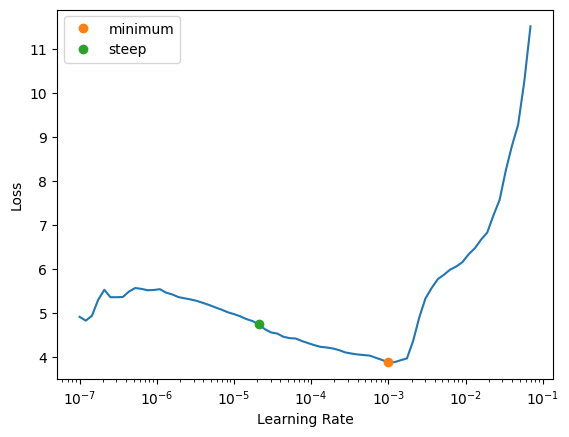

In [9]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from fastai.text.all import *
from typing import List
import os

def read_tales(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        tales = f.read().strip().split('///')
    return [tale.strip() for tale in tales if tale.strip()]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def encodes(self, x):
        # Encoding with special tokens and padding
        toks = self.tokenizer(x, truncation=True, max_length=256, padding='max_length', return_tensors='pt')
        return toks['input_ids'].squeeze()  # Squeeze to get rid of batch dimension
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy(), skip_special_tokens=True))

class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

def train_kogpt2_model(file_path: str):
    # Load data
    tales = read_tales(file_path)

    # Initialize tokenizer and model
    tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
    model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

    # Add pad token to the model config (if not already added)
    model.resize_token_embeddings(len(tokenizer))

    # Split data
    train = tales[:int(len(tales) * 0.8)]
    test = tales[int(len(tales) * 0.8):]
    splits = [[i for i in range(len(train))], [i + len(train) for i in range(len(test))]]

    # Initialize DataLoaders
    tls = TfmdLists(train + test, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
    batch, seq_len = 2, 256
    dls = tls.dataloaders(bs=batch, seq_len=seq_len)

    # Initialize Learner
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                    cbs=[DropOutput], metrics=Perplexity()).to_fp16()

    # Find learning rate
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
    lr = lr_steep or lr_min
    print(f"Suggested learning rate: {lr}")

    # Train model
    learn.fit_one_cycle(5, lr)

    # Save path
    save_path = '/content/drive/MyDrive/Tale/dropout256'
    os.makedirs(save_path, exist_ok=True)

    # Save the trained model
    learn.export(f'{save_path}/koGPT2_model_trained.pkl')

    return learn.model

file_path = "/content/drive/MyDrive/Tale/processed_final.txt"  # Replace with actual file path
trained_model = train_kogpt2_model(file_path)
print("Training completed and model saved.")
